In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType, LongType, DoubleType
from pyspark.sql.functions import lit, isnan, size, col

In [2]:
STS_RAW_TRAIN_FILE = '../data/sts/training.1600000.processed.noemoticon.csv'
STS_RAW_TEST_FILE  = '../data/sts/testdata.manual.2009.06.14.csv'

STS_PROCESED_TRAIN_PATH = '../data/processed/sts/sts_train'
STS_PROCESED_TEST_PATH  = '../data/processed/sts/sts_test'

COVID_PROCESSED_PATH = '../data/processed/full-tweets-sanitized/tweets-sanitized'

In [3]:
spark = SparkSession.builder.master('local').appName('local').getOrCreate()

# Load Data

In [4]:
sts_raw_schema = StructType([
    StructField('label', IntegerType(), True),
    StructField('id', LongType(), True),
    StructField('date', StringType(), True),
    StructField('query', StringType(), True),
    StructField('user', StringType(), True),
    StructField('text', StringType(), True),
])

sts_processed_schema = StructType([
    StructField('id', LongType(), True),
    StructField('text', StringType(), True),
])

covid_processed_schema = StructType([
    StructField('id', LongType(), True),
    StructField('text', StringType(), True),
])

In [5]:
# Google Drive file name     - md5sum 
# Final_preprocessed_sts.csv - ec4e0de0560e2ce9a3c11055b6f41894
# Test_data_processed.csv    - ee4e572acdbb6dc129ca397f7d3f37bc
# 
# Recover the labels from the raw data necessary for training and testing
# 
df_sts_processed_train = spark.read.csv(STS_PROCESED_TRAIN_PATH + '/' + '*.csv', header=False, schema=sts_processed_schema).withColumn('type', lit('train'))
df_sts_processed_test  = spark.read.csv(STS_PROCESED_TEST_PATH + '/' + '*.csv', header=False, schema=sts_processed_schema).withColumn('type', lit('test'))

df_sts_raw_train = spark.read.csv(STS_RAW_TRAIN_FILE, header=False, schema=sts_raw_schema).select('id', 'text', 'label').withColumnRenamed('text', 'raw_text')
df_sts_processed_train_with_labels = df_sts_processed_train.join(df_sts_raw_train, on=['id']).select('id', 'text', 'label', 'type')

df_sts_raw_test = spark.read.csv(STS_RAW_TEST_FILE, header=False, schema=sts_raw_schema).select('id', 'text', 'label').withColumnRenamed('text', 'raw_text')
df_sts_processed_test_with_labels = df_sts_processed_test.join(df_sts_raw_test, on=['id']).select('id', 'text', 'label', 'type')

In [6]:
df_covid_processed     = spark.read.csv(COVID_PROCESSED_PATH + '/' + '*.csv', header=False, schema=covid_processed_schema).select('id', 'text', lit(None).alias('label')).withColumn('type', lit('covid'))

In [7]:
df_all = df_sts_processed_train_with_labels.union(df_sts_processed_test_with_labels).union(df_covid_processed)

In [8]:
# Clean up null rows on text column
df_all = df_all.filter(~ col("text").isNull())

# Build Pipeline
1. Tokenize Words
2. Build Feature Vector

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer

In [10]:
# Hyper Parameters
VOCAB_SIZE = 5000
MIN_DF     = 25

# Default Stop Words
default_stop_words = StopWordsRemover.loadDefaultStopWords("english")

In [11]:
tokenizer          = RegexTokenizer(inputCol="text", outputCol="tokenized_text", pattern="\\W")
stop_words_remover = StopWordsRemover(inputCol="tokenized_text", outputCol="filtered_text").setStopWords(default_stop_words)
vectorizer         = CountVectorizer(inputCol="filtered_text", outputCol="features", vocabSize=VOCAB_SIZE, minDF=MIN_DF)

pipeline = Pipeline(stages=[tokenizer, stop_words_remover, vectorizer])

In [12]:
pipeline_fit = pipeline.fit(df_all)
df_all_fit   = pipeline_fit.transform(df_all)

In [13]:
df_all_fit.show()
df_all.groupBy('type').count().show()

+----------+--------------------+-----+-----+--------------------+--------------------+--------------------+
|        id|                text|label| type|      tokenized_text|       filtered_text|            features|
+----------+--------------------+-----+-----+--------------------+--------------------+--------------------+
|1467860144|hate limit letter...|    0|train|[hate, limit, let...|[hate, limit, let...|(5000,[22,78,87,2...|
|1467862225|website fyi pit w...|    4|train|[website, fyi, pi...|[website, fyi, pi...|(5000,[13,103,151...|
|1467889791|call hillsong sai...|    0|train|[call, hillsong, ...|[call, hillsong, ...|(5000,[3,15,24,36...|
|1467898027|         thought mac|    4|train|      [thought, mac]|      [thought, mac]|(5000,[138,668],[...|
|1467904302|www nicki like ha...|    0|train|[www, nicki, like...|[www, nicki, like...|(5000,[5,60,71,18...|
|1467928749|tire ddd want sle...|    0|train|[tire, ddd, want,...|[tire, ddd, want,...|(5000,[13,32,35,1...|
|1467946810|  mine 

# Train Naive Bayes
Train the NB model

In [14]:
from pyspark.ml.classification import NaiveBayes

In [15]:
df_train = df_all_fit.filter(df_all_fit.type == 'train')
df_test  = df_all_fit.filter(df_all_fit.type == 'test')
df_covid = df_all_fit.filter(df_all_fit.type == 'covid')

In [16]:
nb = NaiveBayes()
model = nb.fit(df_train)

In [17]:
preds = model.transform(df_test)

In [18]:
preds.show()

+---+--------------------+-----+----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| id|                text|label|type|      tokenized_text|       filtered_text|            features|       rawPrediction|         probability|prediction|
+---+--------------------+-----+----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  3|kind cool fantasy...|    4|test|[kind, cool, fant...|[kind, cool, fant...|(5000,[39,124,288...|[-29.564370329849...|[0.08533168728110...|       1.0|
|  4|read kind love le...|    4|test|[read, kind, love...|[read, kind, love...|(5000,[3,4,40,288...|[-48.013191770529...|[0.06673369582312...|       1.0|
|  5|passes kind fuck ...|    4|test|[passes, kind, fu...|[passes, kind, fu...|(5000,[189,272,28...|[-22.161510078466...|[0.39578335310095...|       1.0|
|  6|love kind ive mon...|    4|test|[love, kind, ive,...|[love, kind, ive,.

# Testing Naive Bayes Model

In [19]:
from pyspark.sql.functions import udf

weighted_prob = udf(lambda v: float(v[1]), DoubleType())
preds_weighted = preds.withColumn("weighted_label", weighted_prob("probability")).select("id", "label", "prediction", "weighted_label")

Since the test set include ground truth neutral labels and the training set do not, we use use the predicted weighted label to determine the hard label:

0.0 <= weighted_label < 0.33333: negative

0.33333 <= weighted_label < 0.66666 : neutral

0.66666 <= weighted_label <= 1.0: positive

In [20]:
def get_hard_label(weighted_label):
    if 0.0 <= weighted_label < 0.33333:
        return 0
    elif 0.33333 <= weighted_label < 0.66666:
        return 2
    elif 0.66666 <= weighted_label <= 1.0:
        return 4

hard_label_udf = udf(get_hard_label, IntegerType())

In [21]:
preds_hard_label = preds_weighted.withColumn("predicted_hard_label", hard_label_udf("weighted_label")).select("id", "label", "predicted_hard_label", "weighted_label")

In [22]:
preds_hard_label.show()

+---+-----+--------------------+--------------------+
| id|label|predicted_hard_label|      weighted_label|
+---+-----+--------------------+--------------------+
|  3|    4|                   4|  0.9146683127188987|
|  4|    4|                   4|  0.9332663041768712|
|  5|    4|                   2|  0.6042166468990409|
|  6|    4|                   4|  0.7800568281512443|
|  7|    4|                   2|  0.6213845680020688|
|  8|    4|                   4|   0.834086599819803|
|  9|    0|                   0|0.015525767656515362|
| 10|    4|                   4|  0.8302609352499865|
| 11|    4|                   4|  0.8182199226243227|
| 12|    4|                   4|  0.8270586503982665|
| 13|    2|                   4|  0.9612029957523833|
| 14|    0|                   0|   0.156458720968048|
| 15|    4|                   4|   0.855862775179578|
| 16|    4|                   4|  0.9564093156415147|
| 17|    0|                   0| 0.16634794502051053|
| 18|    4|                 

In [23]:
from pyspark.mllib.evaluation import MulticlassMetrics

prediction_and_labels = preds_hard_label.select("predicted_hard_label", "label") \
                            .withColumn("predicted_hard_label", col("predicted_hard_label").cast(DoubleType())) \
                            .withColumn("label", col("label").cast(DoubleType())) \
                            .rdd
metrics = MulticlassMetrics(prediction_and_labels)

In [24]:
# Statistics by class
labels = [0.0, 2.0, 4.0]
for label in sorted(labels):
    print("Class %s precision = %s" % (label, metrics.precision(label)))
    print("Class %s recall = %s" % (label, metrics.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))

Class 0.0 precision = 0.8129496402877698
Class 0.0 recall = 0.6384180790960452
Class 0.0 F1 Measure = 0.7151898734177216
Class 2.0 precision = 0.5031847133757962
Class 2.0 recall = 0.5683453237410072
Class 2.0 F1 Measure = 0.5337837837837838
Class 4.0 precision = 0.6584158415841584
Class 4.0 recall = 0.7307692307692307
Class 4.0 F1 Measure = 0.6927083333333334


In [25]:
# Weighted stats
print("Weighted recall = %s" % metrics.weightedRecall)
print("Weighted precision = %s" % metrics.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)

Weighted recall = 0.6526104417670682
Weighted precision = 0.6700129410813007
Weighted F(1) Score = 0.656340301621585
Weighted F(0.5) Score = 0.6631909406204497
Weighted false positive rate = 0.16923195186809004


Confusion matrix:
 [[113.0, 42.0, 22.0], [13.0, 79.0, 47.0], [13.0, 36.0, 133.0]]


<ipython-input-36-fe884b6bc445>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-36-fe884b6bc445>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


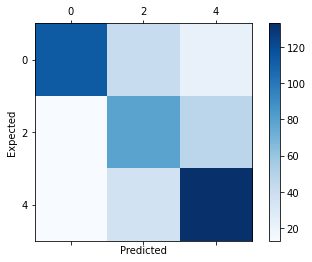

In [36]:
from matplotlib import pyplot as plt

cm = metrics.confusionMatrix().toArray().tolist()
print('Confusion matrix:\n', cm)

labels = ['0', '2', '4']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# Testing Naive Bayes Model (Without Neutral)

In [26]:
def map_prediction(pred):
    if pred == 0.0:
        return 0.0
    elif pred == 1.0:
        return 4.0

map_prediction_udf = udf(map_prediction, DoubleType())

In [29]:
preds_no_neutral = preds.withColumn("prediction_mapped", map_prediction_udf("prediction")).select("label", "prediction_mapped")
preds_no_neutral = preds_no_neutral.filter(preds_no_neutral.label != 2)

+-----+-----------------+
|label|prediction_mapped|
+-----+-----------------+
|    4|              4.0|
|    4|              4.0|
|    4|              4.0|
|    4|              4.0|
|    4|              4.0|
|    4|              4.0|
|    0|              0.0|
|    4|              4.0|
|    4|              4.0|
|    4|              4.0|
|    0|              0.0|
|    4|              4.0|
|    4|              4.0|
|    0|              0.0|
|    4|              4.0|
|    0|              4.0|
|    4|              4.0|
|    0|              4.0|
|    4|              4.0|
|    4|              4.0|
+-----+-----------------+
only showing top 20 rows



In [30]:
prediction_and_labels2 = preds_no_neutral.select("prediction_mapped", "label") \
                            .withColumn("prediction_mapped", col("prediction_mapped").cast(DoubleType())) \
                            .withColumn("label", col("label").cast(DoubleType())) \
                            .rdd
metrics2 = MulticlassMetrics(prediction_and_labels2)

In [33]:
# Statistics by class
labels2 = [0.0, 4.0]
for label in sorted(labels2):
    print("Class %s precision = %s" % (label, metrics2.precision(label)))
    print("Class %s recall = %s" % (label, metrics2.recall(label)))
    print("Class %s F1 Measure = %s" % (label, metrics2.fMeasure(label, beta=1.0)))

Class 0.0 precision = 0.8466257668711656
Class 0.0 recall = 0.7796610169491526
Class 0.0 F1 Measure = 0.8117647058823529
Class 4.0 precision = 0.8010204081632653
Class 4.0 recall = 0.8626373626373627
Class 4.0 F1 Measure = 0.8306878306878307


In [31]:
# Weighted stats
print("Weighted recall = %s" % metrics2.weightedRecall)
print("Weighted precision = %s" % metrics2.weightedPrecision)
print("Weighted F(1) Score = %s" % metrics2.weightedFMeasure())
print("Weighted F(0.5) Score = %s" % metrics2.weightedFMeasure(beta=0.5))
print("Weighted false positive rate = %s" % metrics2.weightedFalsePositiveRate)

Weighted recall = 0.8217270194986073
Weighted precision = 0.82350550145379
Weighted F(1) Score = 0.8213580449202276
Weighted F(0.5) Score = 0.8223415752466294
Weighted false positive rate = 0.17942863991209207


Confusion matrix:
 [[138.0, 39.0], [25.0, 157.0]]


<ipython-input-38-6e46b0e865b9>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([''] + labels)
<ipython-input-38-6e46b0e865b9>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([''] + labels)


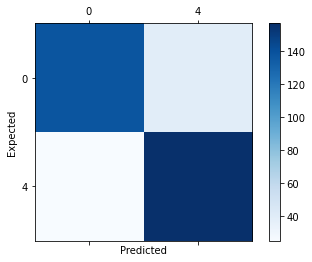

In [38]:
cm2 = metrics2.confusionMatrix().toArray().tolist()
print('Confusion matrix:\n', cm2)

labels = ['0', '4']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm2, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

# Labeling COVID Dataset

In [119]:
COVID_LABELED_PATH = '../data/processed/full-tweets-labeled'

In [120]:
covid_preds = model.transform(df_covid)

In [121]:
covid_preds.show()

+-------------------+--------------------+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                 id|                text|label| type|      tokenized_text|       filtered_text|            features|       rawPrediction|         probability|prediction|
+-------------------+--------------------+-----+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|               null|     fully_processed| null|covid|   [fully_processed]|   [fully_processed]|       (10000,[],[])|[-0.6927803369175...|[0.50018345546886...|       0.0|
|1246892082888945666|local modi sunday...| null|covid|[local, modi, sun...|[local, modi, sun...|(10000,[43,166,29...|[-150.28050776985...|[0.65409787288106...|       0.0|
|1246892725158449152|corona vid fight ...| null|covid|[corona, vid, fig...|[corona, vid, fig...|(10000,[1,43,58,6...|[-157.36454688188...|[0.0234

In [122]:
from pyspark.sql.functions import udf

weighted_prob = udf(lambda v: float(v[1]), DoubleType())
covid_preds_final = covid_preds.withColumn("weighted_label", weighted_prob("probability")).select("id", "prediction", "weighted_label")

In [123]:
covid_preds_final.repartition(1).write.csv(COVID_LABELED_PATH)